### Multi-Company Financial Analysis and Valuation

In [61]:
import yfinance as yf
import pandas as pd
import numpy as np

#### 1. Retrieve Financial Statements for All Companies

In [62]:
def get_financials(ticker):
    try:
        stock = yf.Ticker(ticker)

        pnl = stock.financials  # Income Statement
        bs = stock.balance_sheet  # Balance Sheet
        cf = stock.cashflow  # Cash Flow Statement

        # Concatenate financials into one DataFrame
        fs = pd.concat([pnl, bs, cf])

        if fs.empty:
            return None

        # Replace NaN values with None for better JSON serialization
        fs = fs.replace({np.nan: None})

        # Transpose data so that items are rows and dates are columns
        fs_transposed = fs.T
        fs_transposed['Ticker'] = ticker
        fs_transposed.reset_index(inplace=True)
        fs_transposed.rename(columns={'index': 'Date'}, inplace=True)
        fs_transposed['Date'] = pd.to_datetime(fs_transposed['Date']).dt.year

        # Sort the data by Date and then limit it to the latest 4 years
        fs_transposed = fs_transposed.sort_values(by='Date', ascending=False).head(4)  # Limiting to 4 years

        return fs_transposed

    except Exception as e:
        print(f"Error fetching financials for {ticker}: {e}")
        return None

#### 2. Calculate Financial Ratios for all Stocks

In [63]:
def compute_ratios(financials):
    """Tính các chỉ số tài chính từ bảng financials đã lấy được"""
    try:
        # Map column names to match Yahoo Finance
        column_mappings = {
            "Total Current Assets": "Current Assets",
            "Total Current Liabilities": "Current Liabilities",
            "Total Shareholder Equity": "Stockholders Equity",  # Hoặc 'Common Stock Equity'
            "Total Assets": "Total Assets",
            "Net Income": "Net Income",
            "Total Debt": "Total Debt"
        }

        # Check which columns are in the data and rename them
        for correct_name, yahoo_name in column_mappings.items():
            if yahoo_name in financials.columns:
                financials[correct_name] = financials[yahoo_name]
            else:
                print(f"⚠️ Missing field: {correct_name} (Yahoo name: {yahoo_name})")

        # Check if necessary data is still missing
        missing_fields = [field for field in column_mappings if field not in financials.columns]
        if missing_fields:
            print(f"⚠️ Still missing fields: {', '.join(missing_fields)}")
            return None

        # Calculate financial ratios
        financials["Current Ratio"] = financials["Total Current Assets"] / financials["Total Current Liabilities"]
        financials["Quick Ratio"] = (financials["Total Current Assets"] - financials.get("Inventory", 0)) / financials["Total Current Liabilities"]
        financials["ROE"] = financials["Net Income"] / financials["Total Shareholder Equity"]
        financials["ROA"] = financials["Net Income"] / financials["Total Assets"]
        financials["Debt-to-Equity"] = financials["Total Debt"] / financials["Total Shareholder Equity"]

        # Handling NaN or Infinity
        financials.replace([np.inf, -np.inf], np.nan, inplace=True)

        return financials[["Date", "Ticker", "Current Ratio", "Quick Ratio", "ROE", "ROA", "Debt-to-Equity"]]

    except Exception as e:
        print(f"❌ Error computing ratios: {e}")
        return None

#### 3. In các chỉ số

In [64]:
def get_company_financials(ticker):
    if not ticker:
        print("No ticker provided")
        return

    try:
        financial_data = get_financials(ticker)
        if financial_data is None or financial_data.empty:
            print(f"No financial data found for the given ticker: {ticker}")
            return

        ratios = compute_ratios(financial_data)
        if ratios is not None:
            print("\n📊 Financial Ratios:")
            print(ratios)
        else:
            print("\n⚠️ Unable to compute financial ratios due to missing data.")

    except Exception as e:
        print(f"Failed to fetch stock data: {str(e)}")

#### 4. Dùng thử chương trình (input mã cổ phiếu của 1 công ty bất kỳ)

In [65]:
if __name__ == '__main__':
    ticker = input("Enter a stock ticker: ")
    get_company_financials(ticker)


📊 Financial Ratios:
   Date Ticker  Current Ratio  Quick Ratio       ROE       ROA  Debt-to-Equity
4  2024   MSFT       1.274955     1.265010  0.328281  0.172086        0.250029
3  2023   MSFT       1.769167     1.745163  0.350887  0.175644        0.290777
2  2022   MSFT       1.784607     1.745251  0.436755  0.199370        0.367895
1  2021   MSFT       2.079994     2.050261  0.431522  0.183568        0.477329


##### 📊 Tesla Financial Ratio Analysis (2021-2024)

From **2021 to 2024**, Tesla's financial ratios indicate key changes in its liquidity, profitability, and financial structure:

- **📈 Current Ratio Increased** → Tesla's liquidity improved, meaning it has more short-term assets to cover liabilities.
- **📈 Quick Ratio Increased** → Excluding inventory, Tesla's ability to meet short-term obligations strengthened.
- **📉 ROE Decreased** → Tesla's profitability relative to shareholder equity declined, possibly due to lower margins or increased equity.
- **📉 ROA Decreased** → Tesla is generating lower returns from its assets, indicating efficiency challenges or a larger asset base.
- **📉 Debt-to-Equity Decreased** → Tesla is relying less on debt financing, reducing financial risk but potentially limiting leverage-driven growth.

#### 5. Normalized Stock Price Comparison (2019-2025)

[*********************100%***********************]  7 of 7 completed


<Axes: xlabel='Date'>

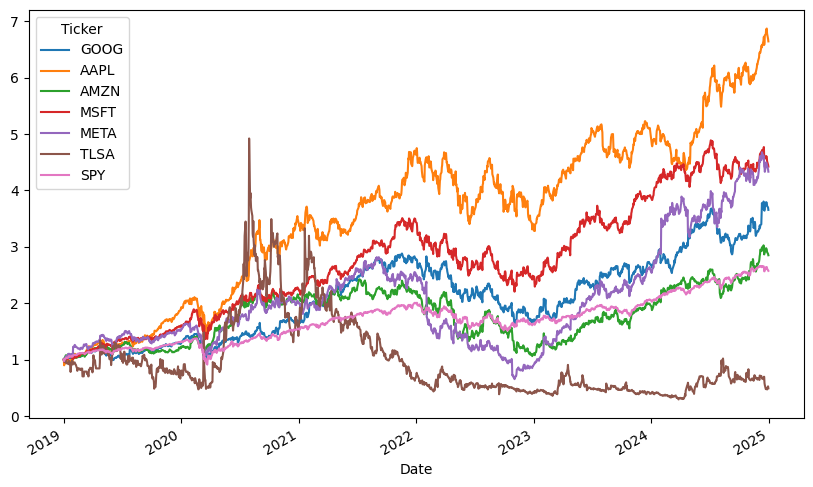

In [66]:
# Normalization: đặt giá cổ phiếu ban đầu thành 1 (hoặc 100%) để so sánh sự thay đổi theo thời gian
tickers = ['GOOG','AAPL','AMZN','MSFT', 'META', 'TLSA', 'SPY'] 
start="2019-01-01"
end="2025-01-01"
raw = yf.download(' '.join(tickers), start, end)['Close']
raw
(raw[tickers]/raw[tickers].iloc[0]).plot(figsize=(10, 6)) # Divide each stock price by its price on first day to see the % increase/decrease in stock price